### Denoising Diffusion Probablisic Models on MNIST digis

In [ ]:
!git clone https://github.com/Daisuke0713/ANN-final.git
%cd ./ANN-final/DDPMs

#### Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import math
from einops import rearrange
from einops.layers.tensorflow import Rearrange
from functools import partial
from inspect import isfunction
from tqdm import tqdm
from PIL import Image

import tensorflow as tf
import keras.layers as nn
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from tensorflow import keras, einsum
from keras import Model, Sequential
from keras.layers import Layer

2023-04-24 12:51:17.006495: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/daisukeyamada/opt/anaconda3/envs/tf/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/Users/daisukeyamada/opt/anaconda3/envs/tf/lib/python3.10/site-packages/tqdm/auto.py:21: Tq

#### GPU/CPU

In [2]:
gpu_device = tf.test.gpu_device_name()
cpu_device = '/cpu:0'
# set CPU the device for now
device = gpu_device

2023-04-24 12:51:22.922318: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
if gpu_device != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(gpu_device))

#### Forward Pass

In [3]:
# hyperparams
image_size = (32, 32)
num_channel = 1
batch_size = 64
timesteps = 200
learning_rate = 1e-4
epochs = 10

# seed
np.random.seed(0)

In [4]:
# get and preprocess dataset
def preprocess(x, _):
    return tf.image.resize(tf.cast(x, tf.float32) / 127.5 - 1, (32, 32))

dataset = tfds.load('mnist', as_supervised=True, split="train")
dataset = dataset.map(preprocess, tf.data.AUTOTUNE)
dataset = dataset.shuffle(5000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
dataset = tfds.as_numpy(dataset)

In [5]:
# define forward pass

'''create variance schedule Beta for t = 1,..,200'''
beta = np.linspace(0.0001, 0.02, timesteps)

'''define alpha for representation trick'''
alpha = 1 - beta
a = np.concatenate((np.array([1.]), np.cumprod(alpha, 0)[:-1]), axis=0) # alpha bar

'''define forward pass'''
def forward(x_0, t):
    with tf.device(device):
        noise_t = np.random.normal(size=x_0.shape)
        sqrt_a_t = np.reshape(np.take(np.sqrt(a), t), (-1, 1, 1, 1))
        sqrt_one_minus_a_t = np.reshape(np.take(np.sqrt(1-a), t), (-1, 1, 1, 1))
        x_t = sqrt_a_t  * x_0 + sqrt_one_minus_a_t  * noise_t
        return noise_t, x_t

2023-04-24 12:51:31.692244: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


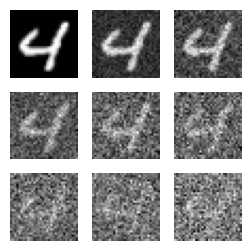

In [6]:
# visualize forward pass

'''show 4x5 images'''
def show_img(x_0, steps):
    plt.figure(figsize=(3,3))
    for i, t in enumerate(steps):
        _, x_t = forward(np.expand_dims(x_0, 0), np.array([t,]))
        plt.subplot(3, 3, i+1)
        plt.imshow(np.squeeze(np.squeeze(x_t,-1),0), cmap='gray')
        plt.axis('off')
    plt.show()

x_0 = next(iter(dataset))[0]
show_img(x_0, [i if i != 200 else 199 for i in range(0,201,25)])


### Reverse (denoising) Pass using U-Net + time embeddings + attention layers

#### 1. Define U-Net for denoising

In [7]:
from u_net import Unet

In [8]:
# instanciate unet
unet = Unet()

# checkpoint (save)
checkpoint = tf.train.Checkpoint(unet=unet)
checkpoint_manager = tf.train.CheckpointManager(
    checkpoint=checkpoint, 
    directory='./checkpoints',
    max_to_keep=2)

# load from checkpoint if any
if checkpoint_manager.latest_checkpoint:
    checkpoint.restore(checkpoint_manager.latest_checkpoint)
    start_interation = int(checkpoint_manager.latest_checkpoint.split("-")[-1])
    print("Loaded the previous model from {}".format(checkpoint_manager.latest_checkpoint))

# define the loss (simple MSE between the actual noise added and the unet prediction)
def loss(noise, predicted):
    with tf.device(device):
        return tf.math.reduce_mean((noise-predicted)**2)

Loaded the previous model from ./checkpoints/ckpt-9


#### 2. Train U-Net

In [10]:
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

def train_step(train_images):
    with tf.device(device):
        # create a "batch" number of random timesteps (in our case 64)
        timestep_values = tf.random.uniform(shape=[train_images.shape[0]], minval=0, maxval=timesteps, dtype=tf.int32)
        
        # forward 
        noised_images, noise = forward(x_0=train_images, t=timestep_values)

        # set the gradient and get the prediction
        with tf.GradientTape() as tape:
            predicted = unet(x=noised_images, time=timestep_values)
            loss_value = loss(noise, predicted)

        # optimize U-Net using ADAM
        gradients = tape.gradient(loss_value, unet.trainable_variables)
        optimizer.apply_gradients(zip(gradients, unet.trainable_variables))

    return loss_value

def train(epochs):
    with tf.device(device):
        # train anumber of epochs time
        for epoch in range(epochs):
            losses = []
            progress = tf.keras.utils.Progbar(len(dataset)-1)
            for i, batch_images in enumerate(iter(dataset)):
                loss = train_step(batch_images)
                losses.append(loss)
                progress.update(i, values=[("loss", loss)])

            print(f'Epoch: {epoch}, Loss: {np.mean(losses)}')
            checkpoint_manager.save(checkpoint_number=epoch)


In [ ]:
# train
train(epochs=epochs)

It takes 12 minutes per epoch.

In [ ]:
!zip -r ./checkpoints.zip checkpoints

Our sampling in the inference looks as follows:
1. Sample a noise $x_T$ from $\mathbb{N(0,1)}$
2. Use U-Net to predict the added noise, denoted $\epsilon$ and obtain the prediction $$x_{T-1} = \frac{1}{\sqrt{\alpha_{T}}}\left(x_{T}-\frac{1-\alpha_{T}}{\sqrt{1-\bar{\alpha_T}}} \cdot \epsilon \right) + \beta_{t}\cdot z,$$
where $z \sim \mathbb{N(0,1)}$.
3. Repeat 2 for $t \in \{T-2, ..., 1\}$.

In [9]:
def denoise_x(x_t, pred_noise, t):
    with tf.device(device):
        # obtain variables
        alpha_t = np.take(alpha, t)
        a_t = np.take(a, t)

        # calculate denoised_x (i.e., x_{t-1})
        beta_t = np.take(beta, t)
        z = np.random.normal(size=x_t.shape)
        denoised_x = (1/np.sqrt(alpha_t)) * (x_t - ((1-alpha_t)/np.sqrt(1-a_t))*pred_noise) + np.sqrt(beta_t) * z
        return denoised_x

def backward(x, i):
    with tf.device(device):
        t = np.expand_dims(np.array(timesteps-i-1, np.int32), 0)
        pred_noise = unet(x, t)
        return denoise_x(x, pred_noise, t)

### Inference

In [10]:
def save_img(imgs, filename=None):
    plt.figure(figsize=(3,3))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(imgs[i], cmap='gray')
        plt.axis('off')
    plt.savefig(f'./images/{filename}.png')

100%|██████████| 199/199 [00:44<00:00,  4.48it/s]


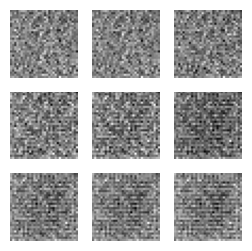

In [12]:
# generate noise
x = tf.random.normal(shape=(1,32,32,1))

# array to store images
imgs = []
imgs.append(np.squeeze(np.squeeze(x, 0),-1))

# backward process

for i in tqdm(range(timesteps-1)):
    x = backward(x, i)
    if i in [0,25,50,75,100,125,150,175,198]:
        imgs.append(np.squeeze(np.squeeze(x, 0),-1))

# save images
save_img(imgs, 'result')